In [5]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, plot_results, split_retrain
from exp_hp import get_hp

Num GPUs Available:  1


### Fuctions

In [7]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
def scheduler(epoch, lr):
    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    if epoch > 10:
        return lr
    else:
        return lr * tf.constant(.9,dtype=tf.float32)
    

# ---------- Two Sequential Convolution Up & Down ----------
def nconv(x, n_filters = 16, n_conv = 1, kernel_size = (3,3), stride = (1,1), padding = 'same', act_func = 'relu',lasso_penalty = 0.0,ridge_penalty = 0.0):
    
    for n in range(n_conv):
        x = layers.Conv2D(filters = n_filters,
                          kernel_size = kernel_size,
                          strides = stride,
                          padding = padding,
                          activation = act_func,
                          use_bias = True,
                          kernel_regularizer = tf.keras.regularizers.l1_l2(l1=lasso_penalty, l2=ridge_penalty),
                          kernel_initializer = tf.keras.initializers.RandomNormal(seed = 1000), 
                          bias_initializer = tf.keras.initializers.RandomNormal(seed = 1000),
                         )(x)

        # x = layers.BatchNormalization()(x)
    
    return x

# ---------- Maxpooling ----------
def maxpool(x, pool_size = (2,2), stride = (2,2), padding = 'valid'): # halve image size
    
    x = layers.MaxPool2D(pool_size = pool_size,
                         strides = stride,
                         padding = padding
                        )(x)
    
    return x

In [8]:
POOL_SIZE = (2,2)
KERNEL_SIZE = (2,2)
STRIDE = (2,2)
n_conv = 2
def create_cnn(input_shape, n_filters_list, n_output, hiddens, denseRIDGE, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    cnn_input = keras.Input(shape = input_shape)
    
    # ----- first cnn layer -----
    x = nconv(x = cnn_input, n_filters = n_filters_list[0], n_conv = n_conv, kernel_size = KERNEL_SIZE, ridge_penalty = 0)
    
    # ----- cnn -----
    for i in np.arange(1,len(n_filters_list)):
        # ----- internal layers -----
        x = maxpool(x, pool_size = POOL_SIZE, stride = STRIDE, padding = 'same')
        x = nconv(x = x, n_filters = n_filters_list[i], n_conv = n_conv, kernel_size = KERNEL_SIZE)

        
    # ----- flatten -----
    x = maxpool(x, pool_size = POOL_SIZE, stride = STRIDE, padding = 'same')
    x = tf.keras.layers.Flatten()(x)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=denseRIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
                
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        # x = tf.keras.layers.BatchNormalization(axis=1)(x) # axis = 1 = average over batch axis [none, batch, lat, lon, maps]

        
        
    # ----- output -----
    cnn_output = tf.keras.layers.Dense(n_output,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    cnn = keras.Model(cnn_input, cnn_output, name = 'cnn')
    
    return cnn

### Load standardized CESM2-LE

In [9]:
EXP_NAME = 'exp2'

hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E


In [10]:
%%time
Xtrain, Xval, _, Ytrain, Yval, _, _ = split_SDbias(trainmems = hps['train_mems'],
                                                      valmem = hps['val_mems'][0],
                                                      testmem = hps['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD'])
input_shape = np.shape(np.expand_dims(Xtrain, axis=-1))[1:]

files do not exist - loading data & saving
CPU times: user 9.62 s, sys: 1.43 s, total: 11.1 s
Wall time: 12.9 s


### Train NN

In [11]:
# ---------- CNN Hyperparameters ----------
NLABEL = 2
HIDDENS = [128] 
BATCH_SIZE = 256
N_EPOCHS = 100
LR_INIT = 0.0001
# MOM = 0.5
RIDGE = 0.0
PATIENCE = 20
N_FILTERS = [128,4]
DROPOUT = 0.9
# SEED = 1
GLOBAL_SEED = 99

0


2024-08-14 10:38:37.629270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-08-14 10:38:39.306768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-14 10:38:39.681475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-14 10:38:41.270729: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x14d2843afcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-14 10:38:41.270793: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-08-14 10:38:41.277922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:26

Elapsed time during fit = 2.30 minutes



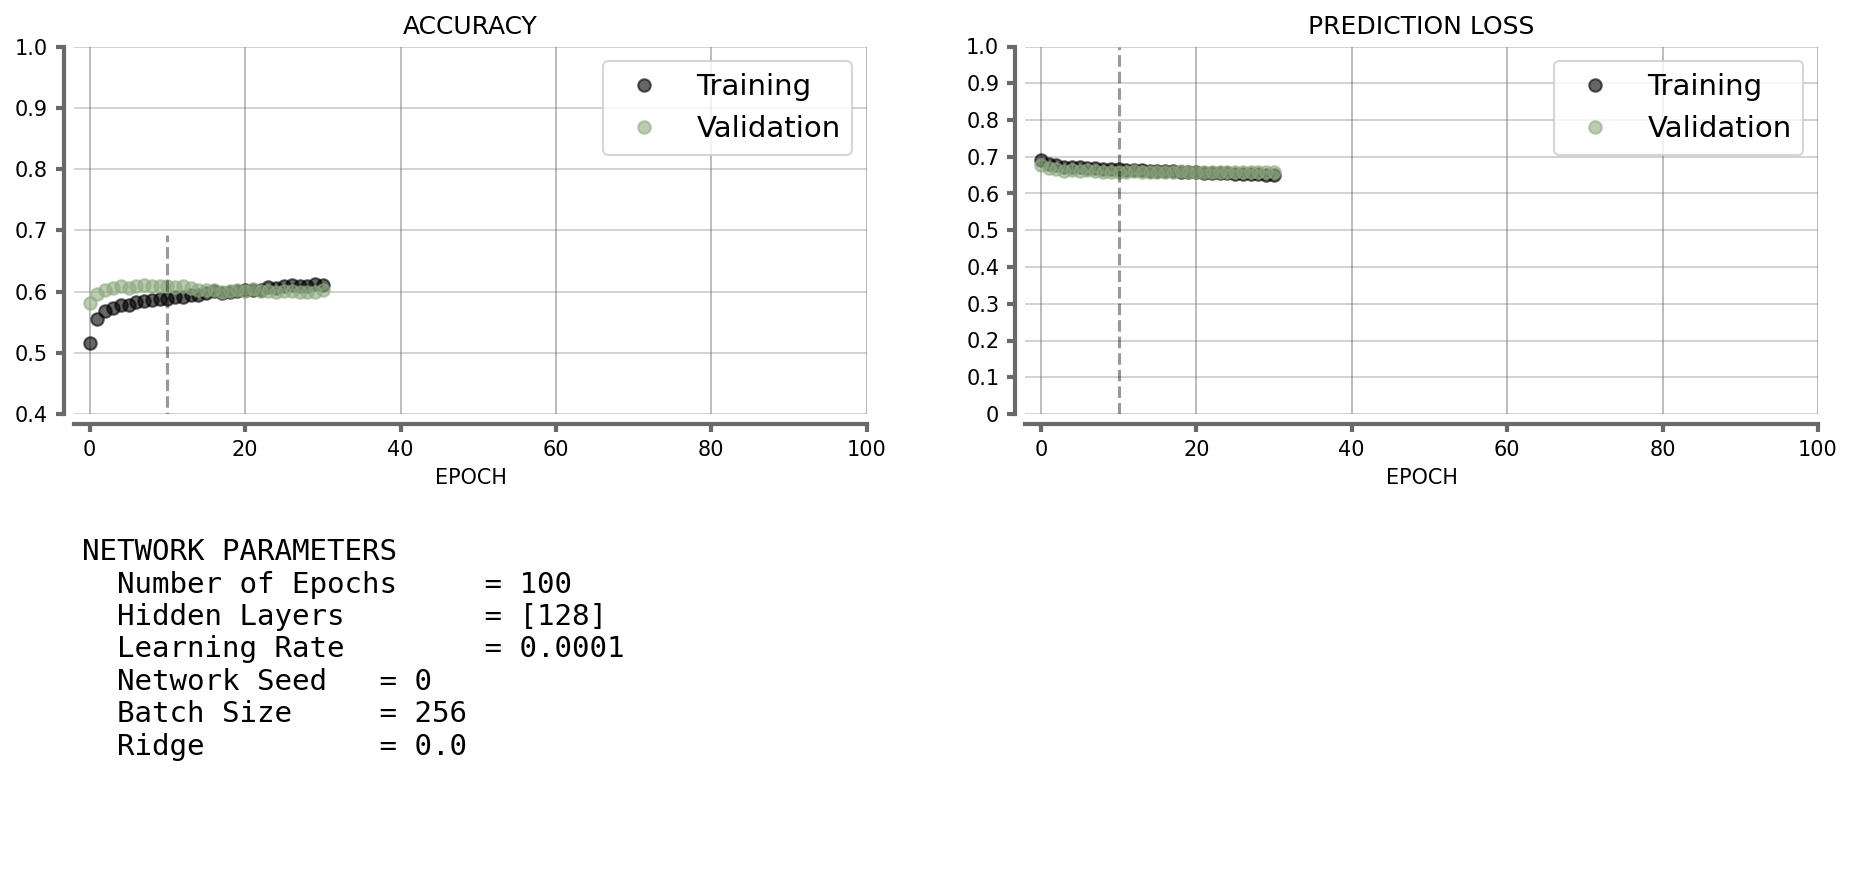

1
Elapsed time during fit = 2.96 minutes



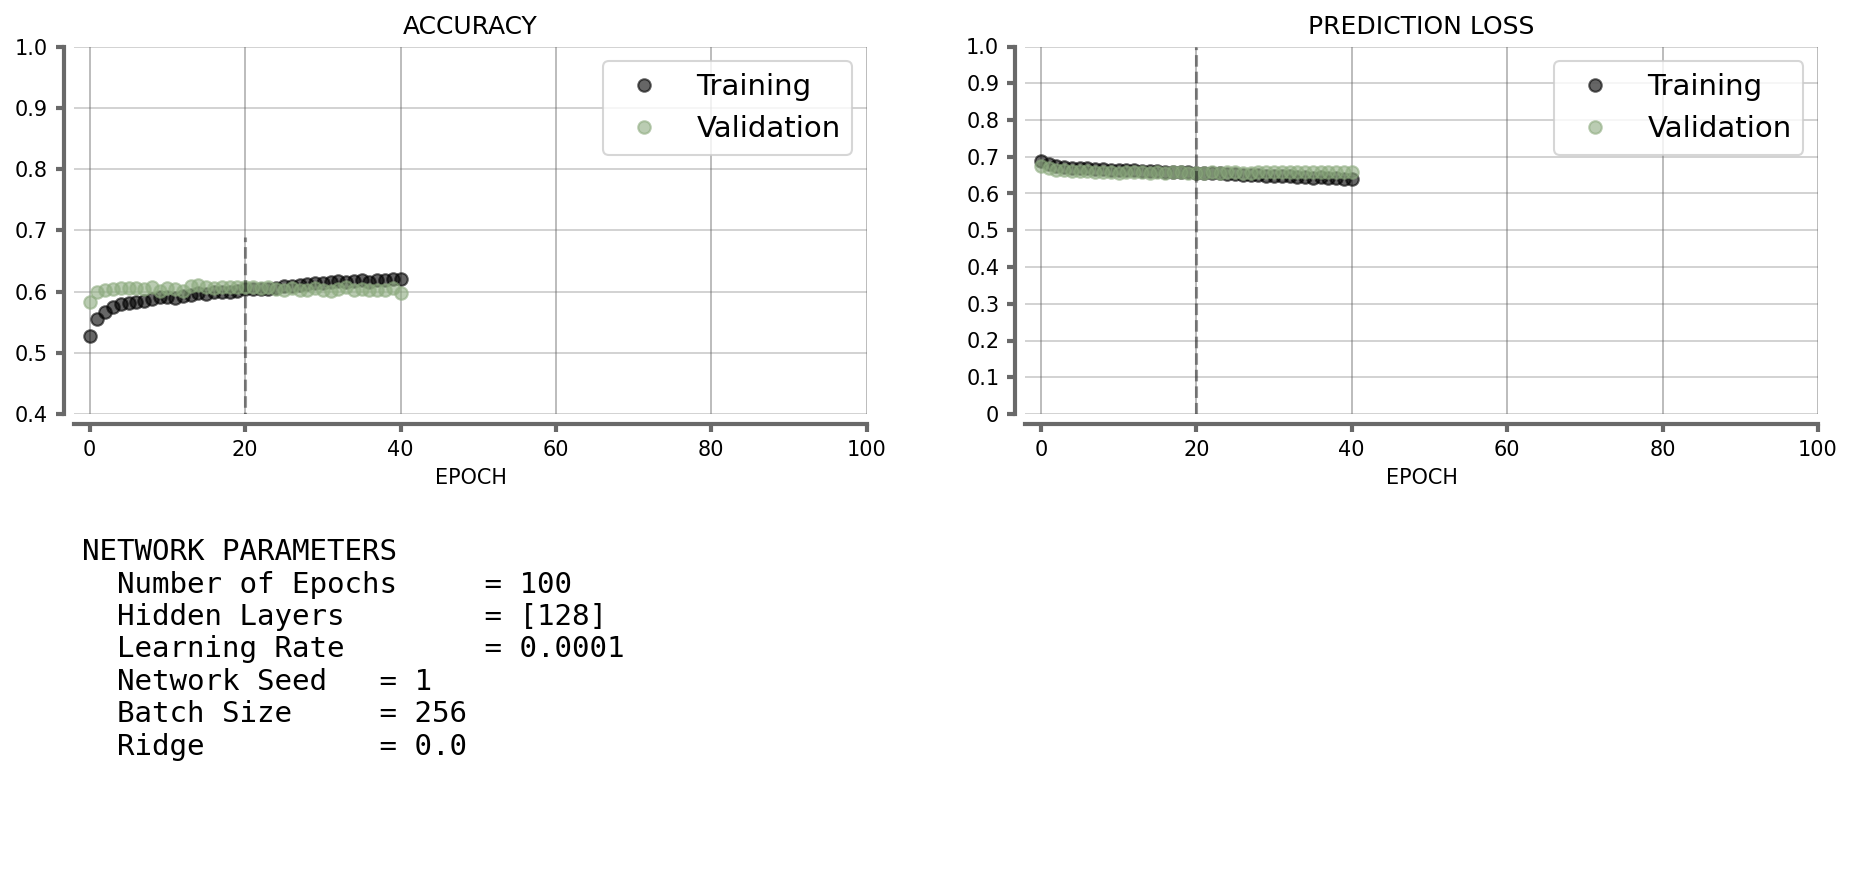

2
Elapsed time during fit = 2.95 minutes



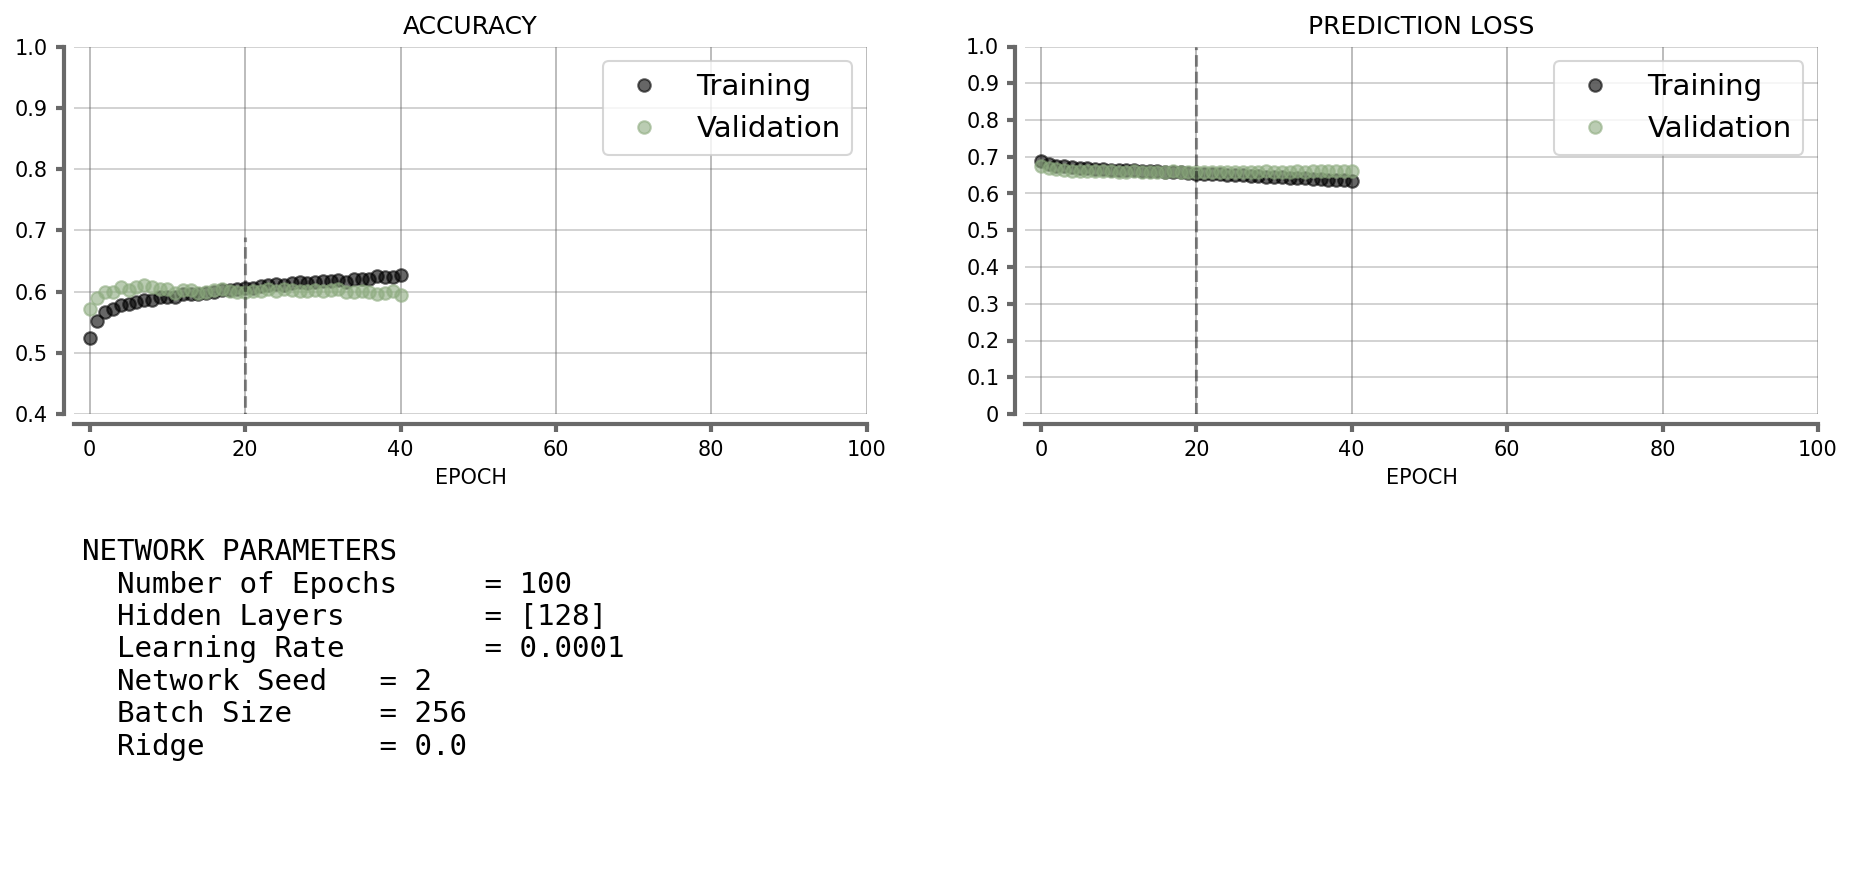

3
Elapsed time during fit = 2.25 minutes



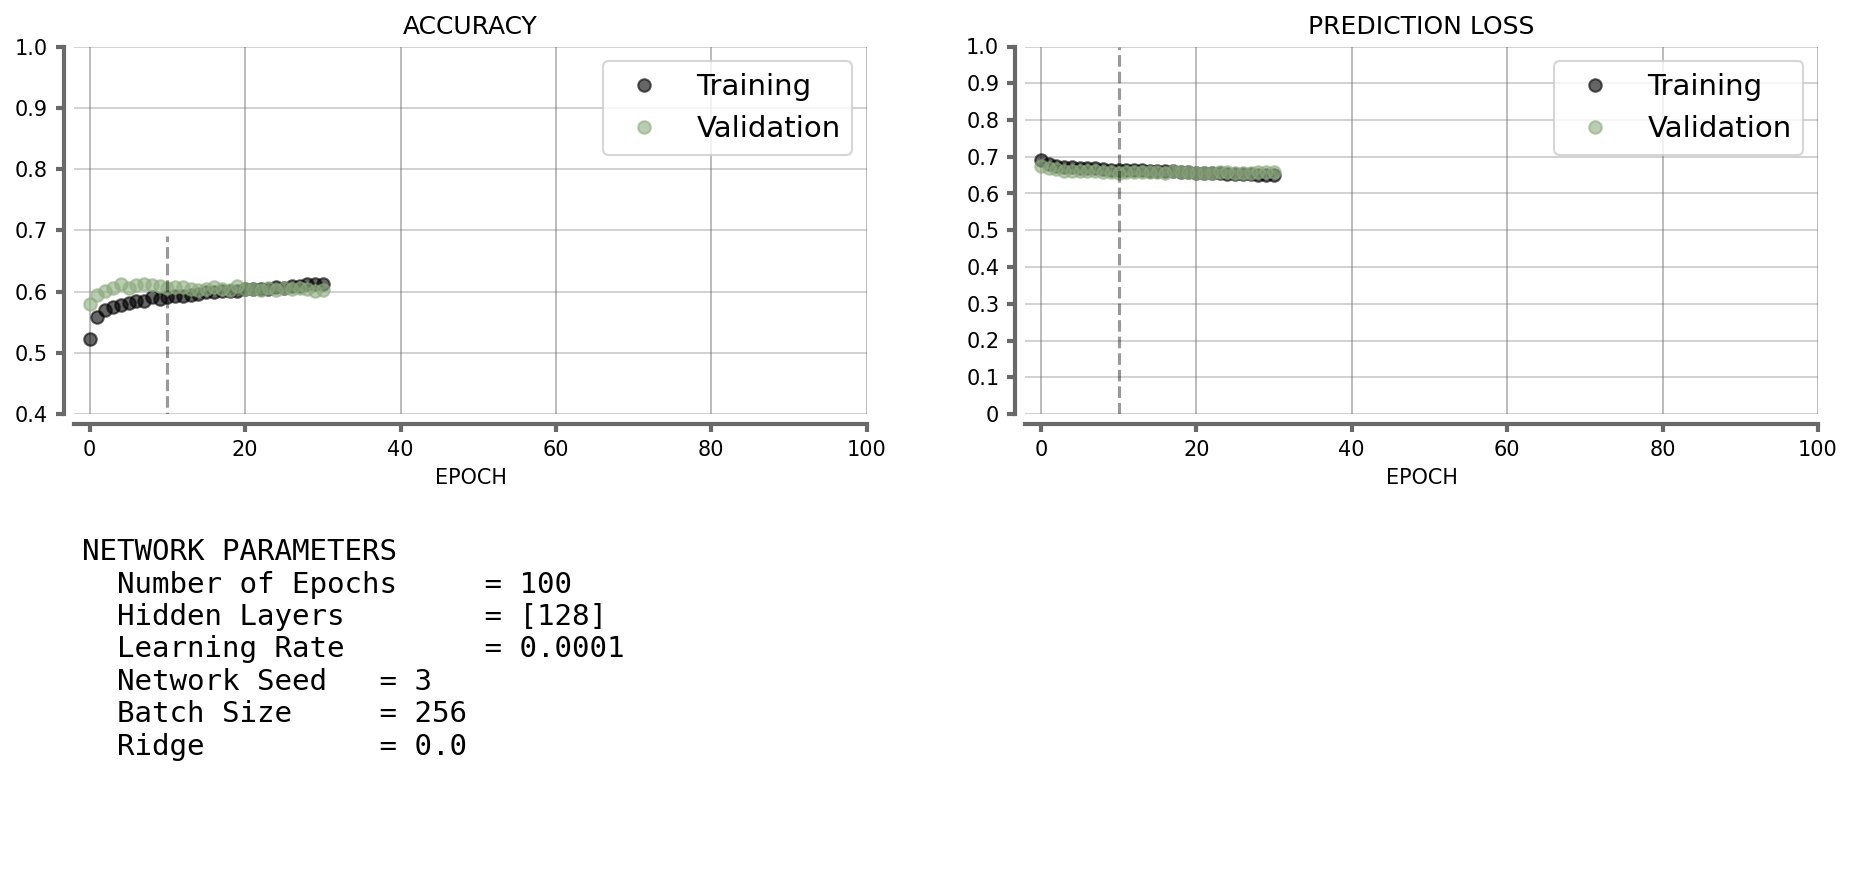

4
Elapsed time during fit = 2.96 minutes



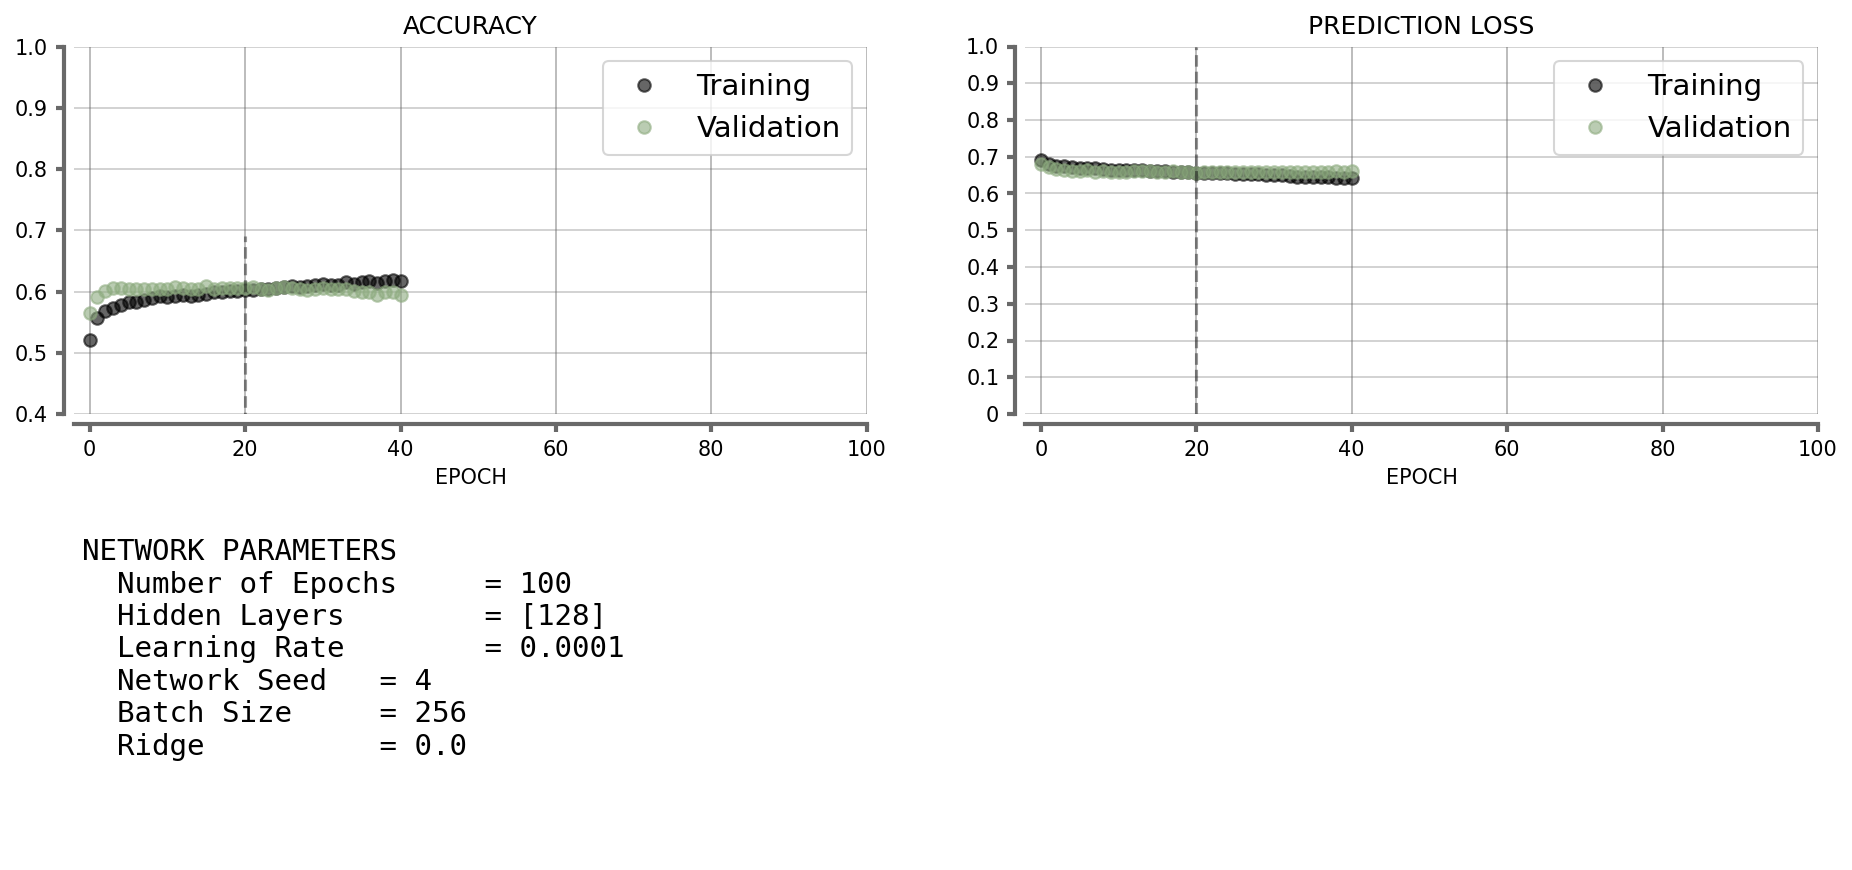

5
Elapsed time during fit = 2.89 minutes



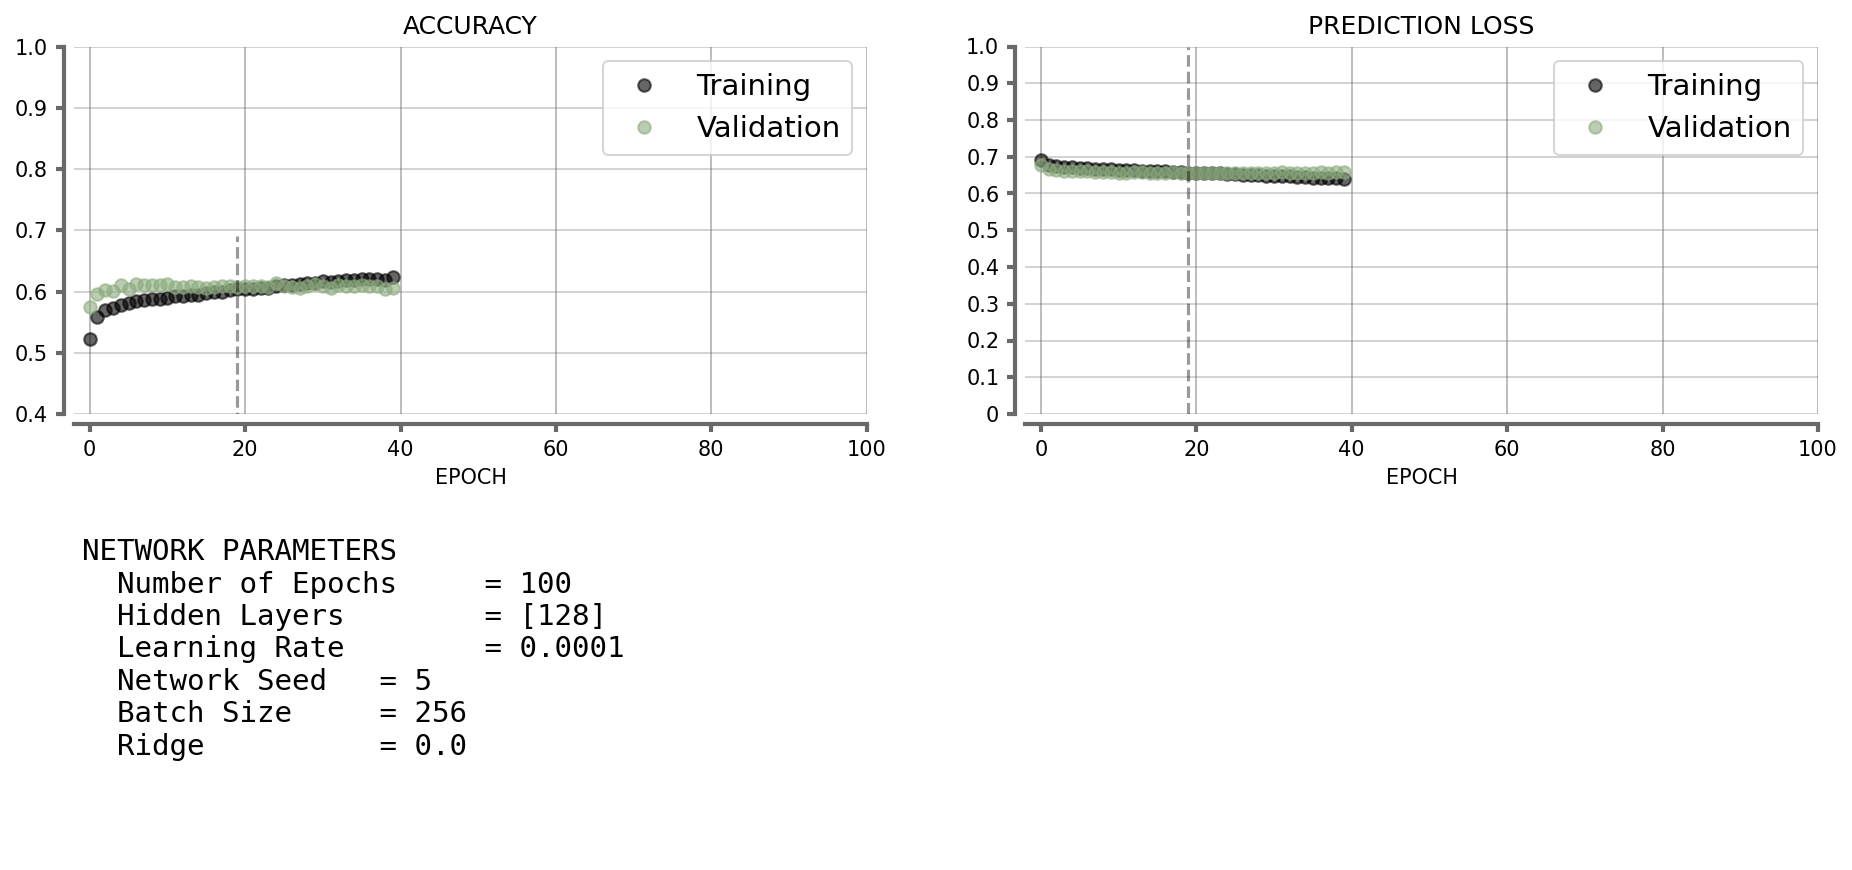

6
Elapsed time during fit = 3.05 minutes



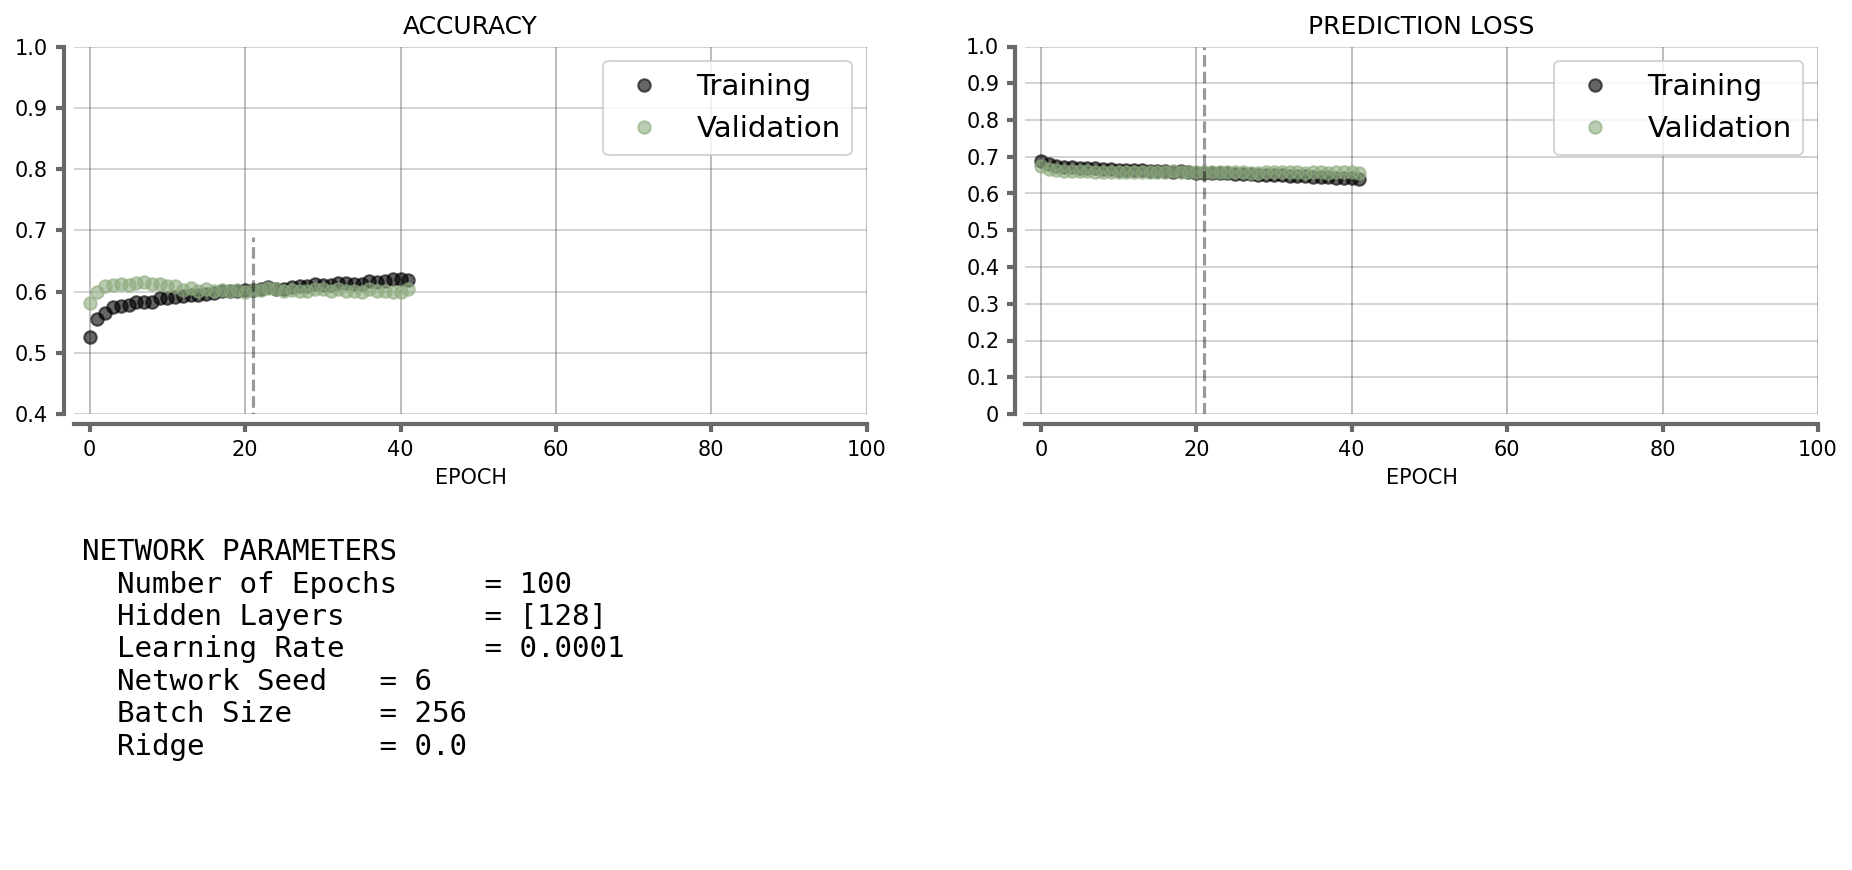

7
Elapsed time during fit = 2.27 minutes



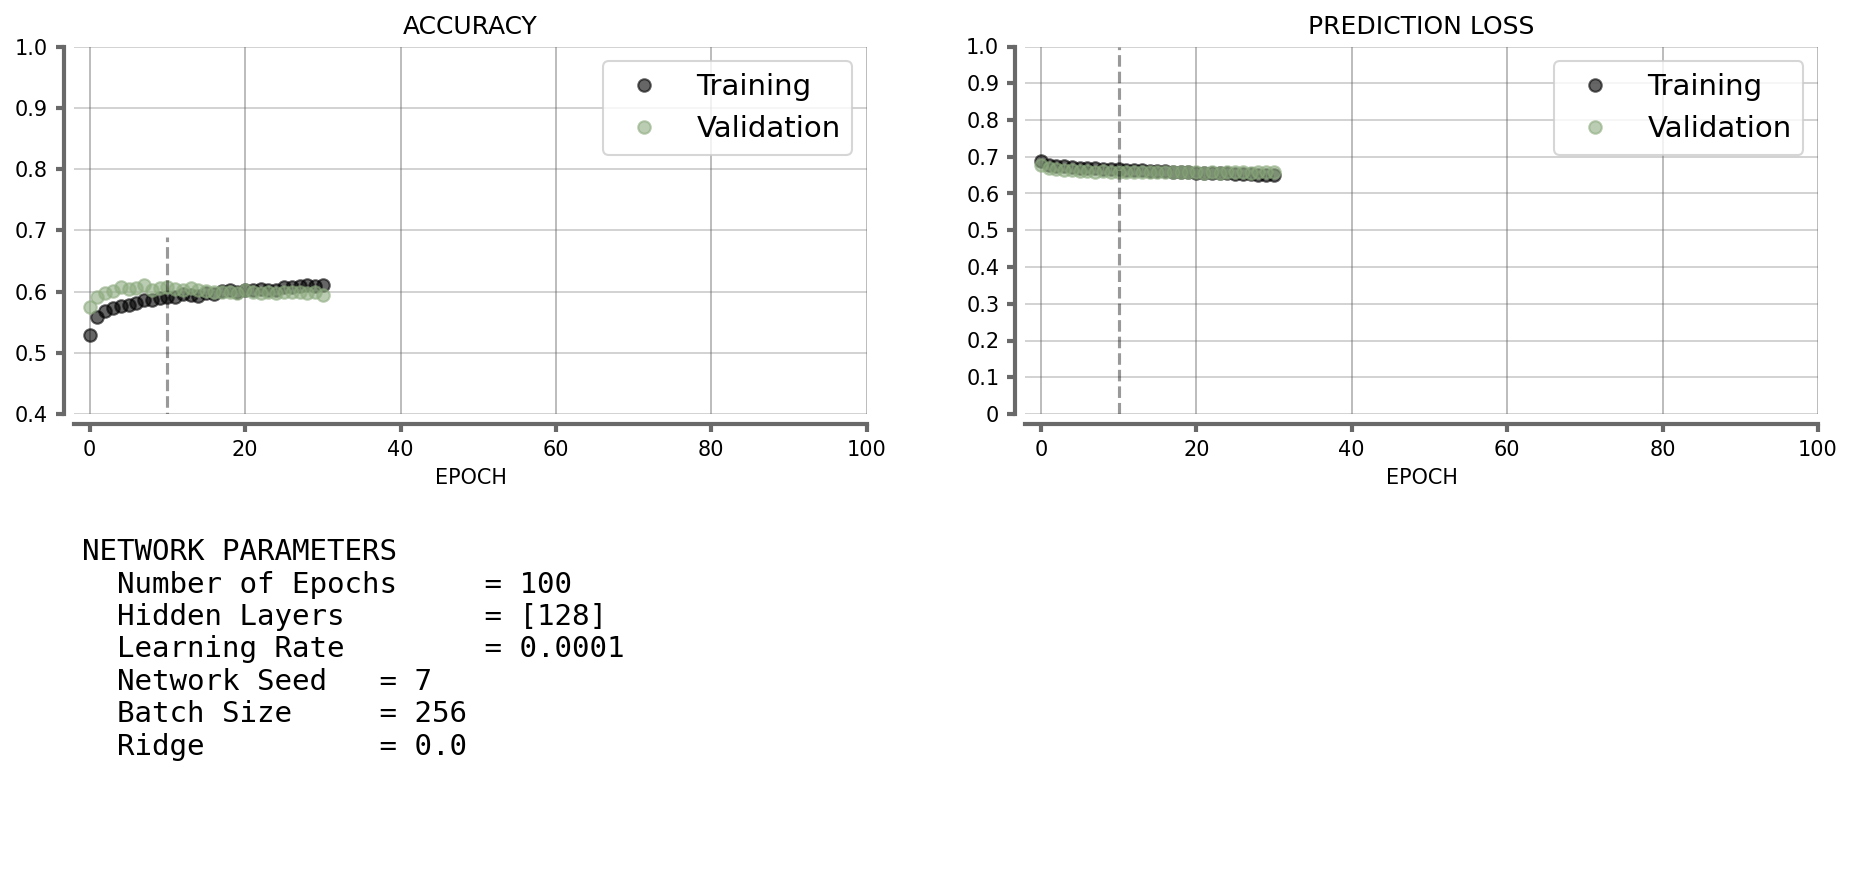

8
Elapsed time during fit = 3.21 minutes



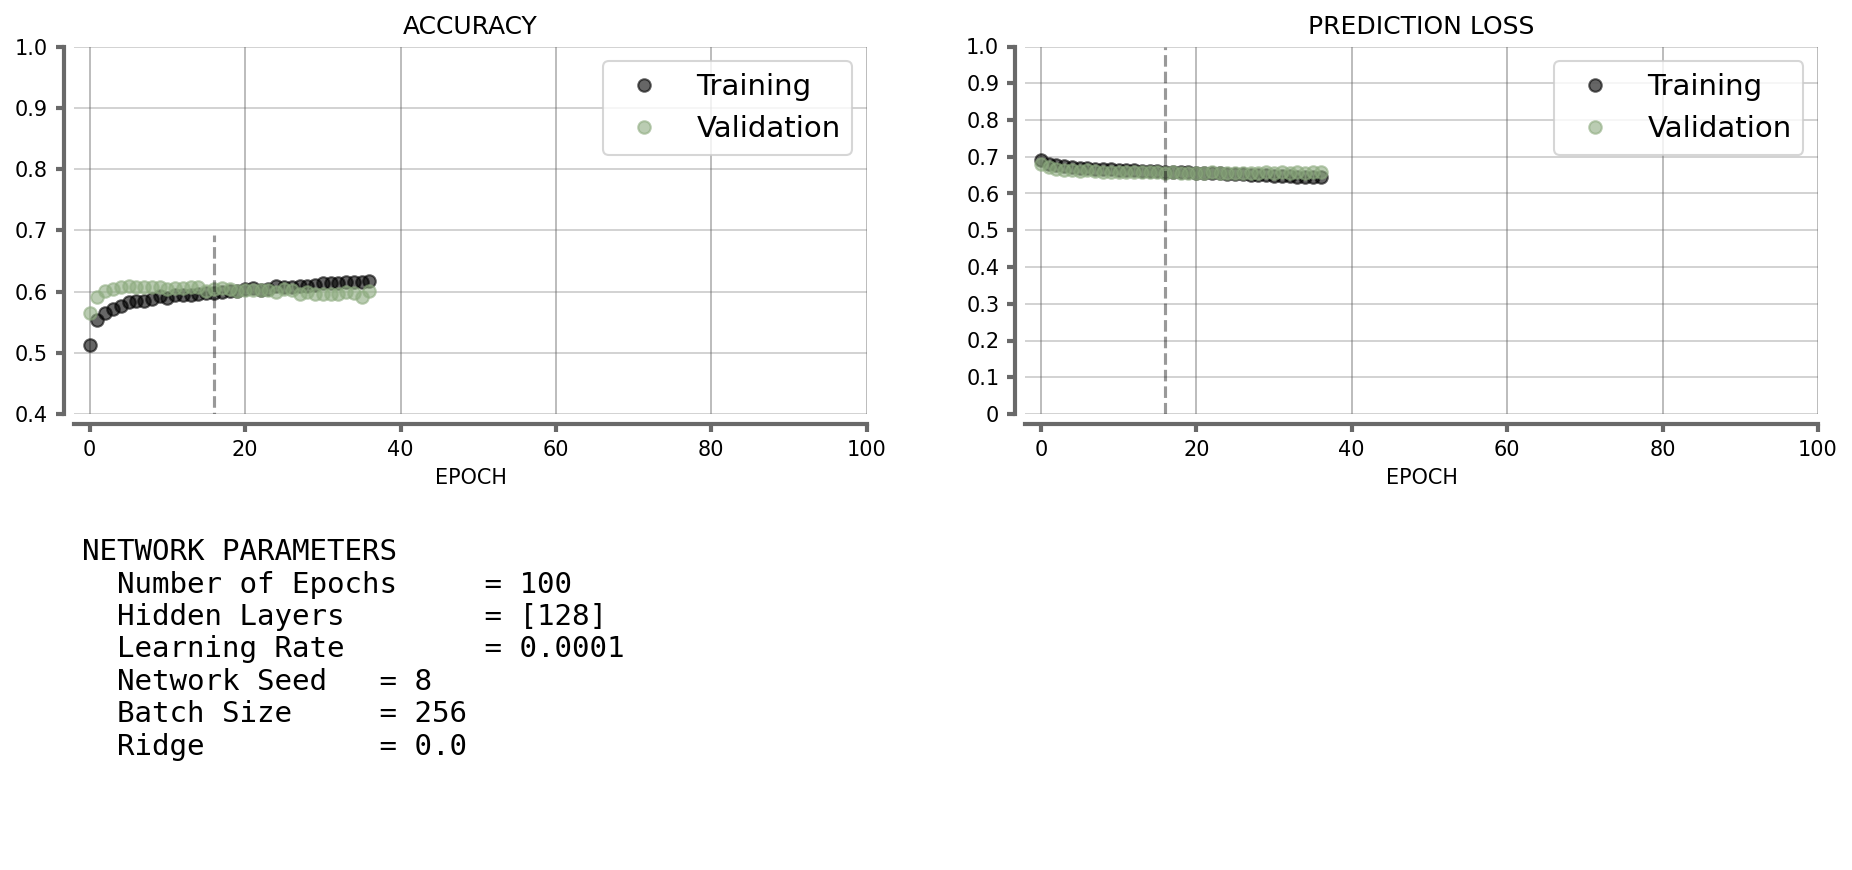

9
Elapsed time during fit = 2.91 minutes



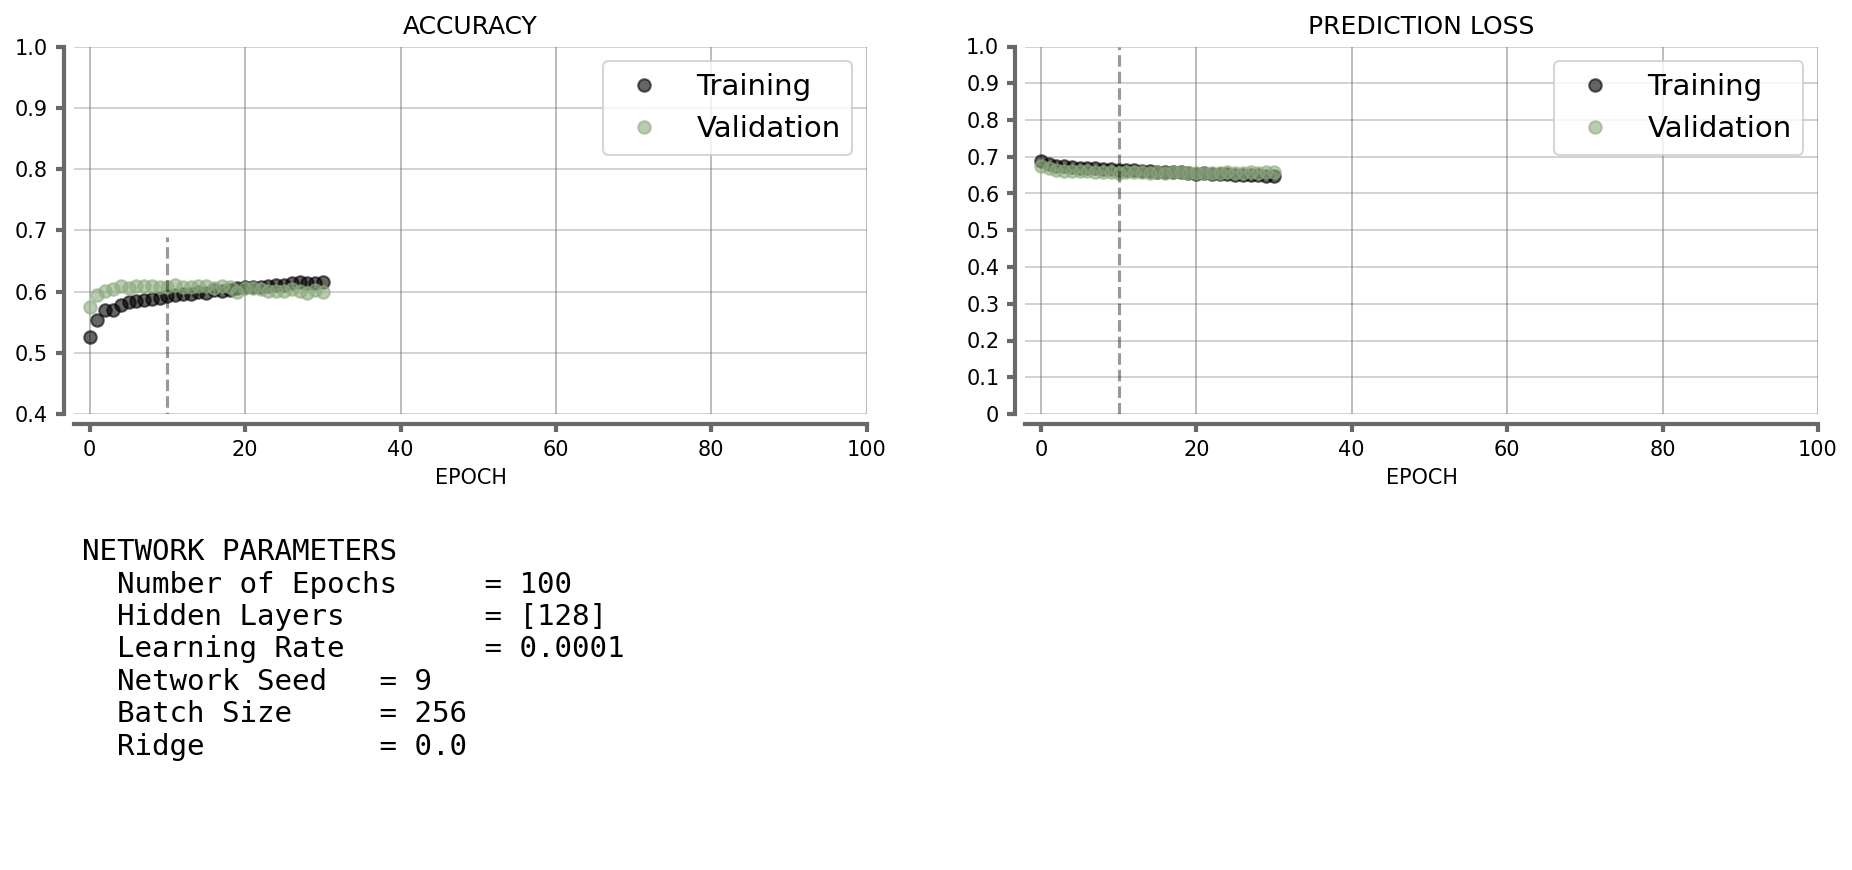

In [12]:
#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for SEED in range(10):
    print(SEED)
    tf.keras.backend.clear_session() 

    # ------ define NN ------
    cnn = create_cnn(input_shape = input_shape,
                     n_filters_list = N_FILTERS,
                     n_output = NLABEL,
                     hiddens=HIDDENS,
                     denseRIDGE=RIDGE,
                     dropout = True, dropout_rate = DROPOUT)

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate = LR_INIT,)#SGD(learning_rate = LR_INIT,
    #                               momentum = MOM) # determines the number of previously seen training samples are used to update weights
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    cnn.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    # LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

    # ------ Train -----
    start_time = time.time()
    history = cnn.fit(Xtrain,Ytrain,
                      validation_data = [Xval,Yval],
                      batch_size = BATCH_SIZE,
                      epochs = N_EPOCHS,
                      shuffle = True,
                      verbose = 0,
                      callbacks = [ES])#,LR])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time)/60.:.2f} minutes\n")
    
    #----- PLOT THE RESULTS -----
    plot_results(
        history,
        exp_info=(100, HIDDENS, LR_INIT, BATCH_SIZE, SEED, PATIENCE, RIDGE),
        showplot=True
    ) 
    
    cnnfi_name = 'cnn1_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    cnndir_name = base_dir+'CNNcheck/saved_models/'
    cnn.save(cnndir_name+cnnfi_name)

In [ ]:
# cnn.summary()